## Alternative Model (Training)

I've found WaveRNN quite slow to train so here's an alternative that utilises the optimised rnn kernels in Pytorch. The model below is much much faster to train, it will converge in 48hrs when training on 22.5kHz samples (or 24hrs using 16kHz samples) on a single GTX1080. It also works quite well with predicted GTA features. 

The model is simply two residual GRUs in sequence and then three dense layers with a 512 softmax output. This is supplemented with an upsampling network.

Since the Pytorch rnn kernels are 'closed', the options for conditioning sites are greatly reduced. Here's the strategy I went with given that restriction:  

1 - Upsampling: Nearest neighbour upsampling followed by 2d convolutions with 'horizontal' kernels to interpolate. Split up into two or three layers depending on the stft hop length.

2 - A 1d resnet with a 5 wide conv input and 1x1 res blocks. Not sure if this is necessary, but the thinking behind it is: the upsampled features give a local view of the conditioning - why not supplement that with a much wider view of conditioning features, including a peek at the future. One thing to note is that the resnet is computed only once and in parallel, so it shouldn't slow down training/generation much. 

There's a good chance this model needs regularisation since it overfits a little, so for now train it to ~500k steps for best results.

In [1]:
cd /home/erogol/Projects/WaveRNN/

/home/erogol/Projects/WaveRNN


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import math, pickle, os
import numpy as np
import torch
from torch.autograd import Variable 
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from utils.display import *
from utils.audio import AudioProcessor
from utils.generic_utils import load_config
from tqdm import tqdm_notebook as tqdm
torch.backends.cudnn.benchmark=False

In [3]:
config_path = '../TTS/config.json'

CONFIG = load_config(config_path)
ap = AudioProcessor(CONFIG.sample_rate, CONFIG.num_mels, CONFIG.min_level_db,
                    CONFIG.frame_shift_ms, CONFIG.frame_length_ms,
                    CONFIG.ref_level_db, CONFIG.num_freq, CONFIG.power, CONFIG.preemphasis,
                    griffin_lim_iters=50)   

 > Setting up Audio Processor...
 | > fft size: 2048, hop length: 275, win length: 1100


In [4]:
bits = 9

seq_len = ap.hop_length * 5
seq_len

notebook_name = 'wavernn_ljspeech'

%mkdir -p 'model_checkpoints/'

MODEL_PATH = f'model_checkpoints/{notebook_name}.pyt'
DATA_PATH = f'data/{notebook_name}/'
STEP_PATH = f'model_checkpoints/{notebook_name}_step.npy'
GEN_PATH = f'model_outputs/{notebook_name}/'
%mkdir -p $GEN_PATH

## Dataset

In [5]:
with open(f'{DATA_PATH}dataset_ids.pkl', 'rb') as f:
    dataset_ids = pickle.load(f)

In [6]:
test_ids = dataset_ids[-50:]
dataset_ids = dataset_ids[:-50]

In [7]:
class AudiobookDataset(Dataset):
    def __init__(self, ids, path):
        self.path = path
        self.metadata = ids
        
    def __getitem__(self, index):
        file = self.metadata[index]
        m = np.load(f'{self.path}mel/{file}.npy')
        x = np.load(f'{self.path}quant/{file}.npy')
        return m, x

    def __len__(self):
        return len(self.metadata)

In [8]:
def collate(batch) :
    
    pad = 2
    mel_win = seq_len // ap.hop_length + 2 * pad
    max_offsets = [x[0].shape[-1] - (mel_win + 2 * pad) for x in batch]
    mel_offsets = [np.random.randint(0, offset) for offset in max_offsets]
    sig_offsets = [(offset + pad) * ap.hop_length for offset in mel_offsets]
    
    mels = [x[0][:, mel_offsets[i]:mel_offsets[i] + mel_win] \
            for i, x in enumerate(batch)]
    
    coarse = [x[1][sig_offsets[i]:sig_offsets[i] + seq_len + 1] \
              for i, x in enumerate(batch)]
    
    mels = np.stack(mels).astype(np.float32)
    coarse = np.stack(coarse).astype(np.int64)
    
    mels = torch.FloatTensor(mels)
    coarse = torch.LongTensor(coarse)
    
    x_input = 2 * coarse[:, :seq_len].float() / (2**bits - 1.) - 1.
    
    y_coarse = coarse[:, 1:]
    
    return x_input, mels, y_coarse

In [9]:
dataset = AudiobookDataset(dataset_ids, DATA_PATH)

In [10]:
data_loader = DataLoader(dataset, collate_fn=collate, batch_size=32, 
                         num_workers=0, shuffle=True)

In [11]:
len(dataset)

13050

In [12]:
x, m, y = next(iter(data_loader))
x.shape, m.shape, y.shape

(torch.Size([32, 1375]), torch.Size([32, 80, 9]), torch.Size([32, 1375]))

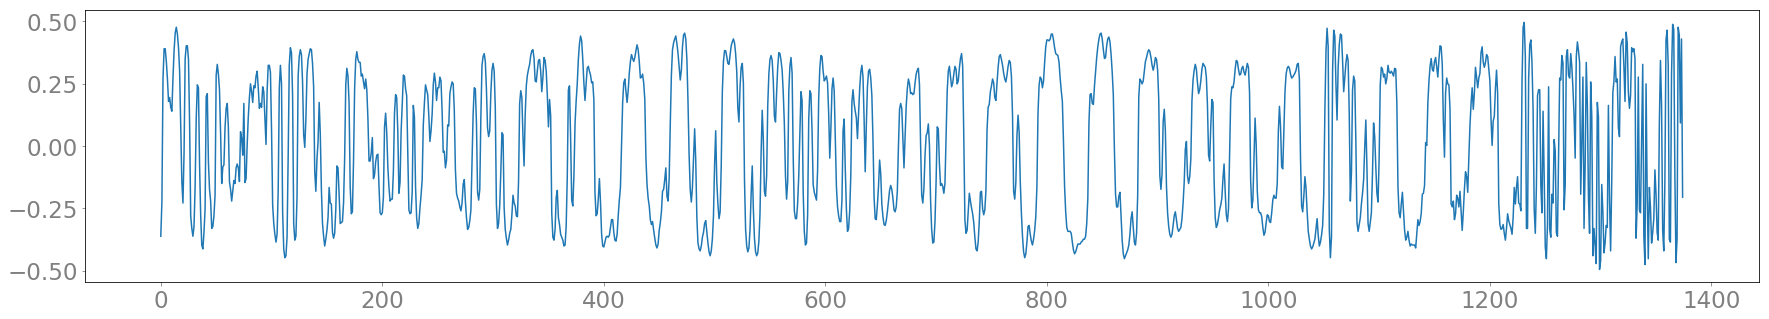

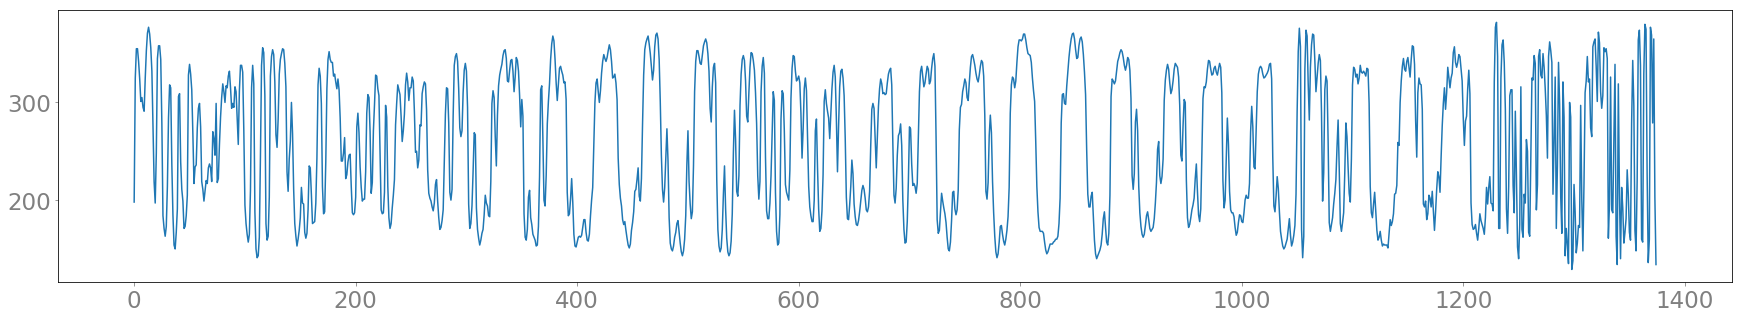

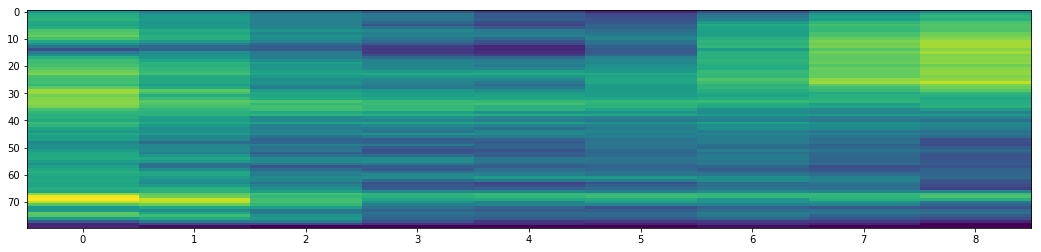

In [13]:
plot(x.numpy()[0]) 
plot(y.numpy()[0])
plot_spec(m.numpy()[0])

## Define Model Classes

In [14]:
class ResBlock(nn.Module) :
    def __init__(self, dims) :
        super().__init__()
        self.conv1 = nn.Conv1d(dims, dims, kernel_size=1, bias=False)
        self.conv2 = nn.Conv1d(dims, dims, kernel_size=1, bias=False)
        self.batch_norm1 = nn.BatchNorm1d(dims)
        self.batch_norm2 = nn.BatchNorm1d(dims)
        
    def forward(self, x) :
        residual = x
        x = self.conv1(x)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.batch_norm2(x)
        return x + residual

In [15]:
class MelResNet(nn.Module) :
    def __init__(self, res_blocks, in_dims, compute_dims, res_out_dims) :
        super().__init__()
        self.conv_in = nn.Conv1d(in_dims, compute_dims, kernel_size=5, bias=False)
        self.batch_norm = nn.BatchNorm1d(compute_dims)
        self.layers = nn.ModuleList()
        for i in range(res_blocks) :
            self.layers.append(ResBlock(compute_dims))
        self.conv_out = nn.Conv1d(compute_dims, res_out_dims, kernel_size=1)
        
    def forward(self, x) :
        x = self.conv_in(x)
        x = self.batch_norm(x)
        x = F.relu(x)
        for f in self.layers : x = f(x)
        x = self.conv_out(x)
        return x        

In [16]:
class Stretch2d(nn.Module) :
    def __init__(self, x_scale, y_scale) :
        super().__init__()
        self.x_scale = x_scale
        self.y_scale = y_scale
        
    def forward(self, x) :
        b, c, h, w = x.size()
        x = x.unsqueeze(-1).unsqueeze(3)
        x = x.repeat(1, 1, 1, self.y_scale, 1, self.x_scale)
        return x.view(b, c, h * self.y_scale, w * self.x_scale)

In [17]:
class UpsampleNetwork(nn.Module) :
    def __init__(self, feat_dims, upsample_scales, compute_dims, 
                 res_blocks, res_out_dims, pad) :
        super().__init__()
        total_scale = np.cumproduct(upsample_scales)[-1]
        self.indent = pad * total_scale
        self.resnet = MelResNet(res_blocks, feat_dims, compute_dims, res_out_dims)
        self.resnet_stretch = Stretch2d(total_scale, 1)
        self.up_layers = nn.ModuleList()
        for scale in upsample_scales :
            k_size = (1, scale * 2 + 1)
            padding = (0, scale)
            stretch = Stretch2d(scale, 1)
            conv = nn.Conv2d(1, 1, kernel_size=k_size, padding=padding, bias=False)
            conv.weight.data.fill_(1. / k_size[1])
            self.up_layers.append(stretch)
            self.up_layers.append(conv)
    
    def forward(self, m) :
        aux = self.resnet(m).unsqueeze(1)
        aux = self.resnet_stretch(aux)
        aux = aux.squeeze(1)
        m = m.unsqueeze(1)
        for f in self.up_layers : m = f(m)
        m = m.squeeze(1)[:, :, self.indent:-self.indent]
        return m.transpose(1, 2), aux.transpose(1, 2)

In [18]:
class Model(nn.Module) :
    def __init__(self, rnn_dims, fc_dims, bits, pad, upsample_factors,
                 feat_dims, compute_dims, res_out_dims, res_blocks):
        super().__init__()
        self.n_classes = 2**bits
        self.rnn_dims = rnn_dims
        self.aux_dims = res_out_dims // 4
        self.upsample = UpsampleNetwork(feat_dims, upsample_factors, compute_dims, 
                                        res_blocks, res_out_dims, pad)
        self.I = nn.Linear(feat_dims + self.aux_dims + 1, rnn_dims)
        self.rnn1 = nn.GRU(rnn_dims, rnn_dims, batch_first=True)
        self.rnn2 = nn.GRU(rnn_dims + self.aux_dims, rnn_dims, batch_first=True)
        self.fc1 = nn.Linear(rnn_dims + self.aux_dims, fc_dims)
        self.fc2 = nn.Linear(fc_dims + self.aux_dims, fc_dims)
        self.fc3 = nn.Linear(fc_dims, self.n_classes)
        num_params(self)
    
    def forward(self, x, mels) :
        bsize = x.size(0)
        h1 = torch.zeros(1, bsize, self.rnn_dims).cuda()
        h2 = torch.zeros(1, bsize, self.rnn_dims).cuda()
        mels, aux = self.upsample(mels)
        
        aux_idx = [self.aux_dims * i for i in range(5)]
        a1 = aux[:, :, aux_idx[0]:aux_idx[1]]
        a2 = aux[:, :, aux_idx[1]:aux_idx[2]]
        a3 = aux[:, :, aux_idx[2]:aux_idx[3]]
        a4 = aux[:, :, aux_idx[3]:aux_idx[4]]
        
        x = torch.cat([x.unsqueeze(-1), mels, a1], dim=2)
        x = self.I(x)
        res = x
        x, _ = self.rnn1(x, h1)
        
        x = x + res
        res = x
        x = torch.cat([x, a2], dim=2)
        x, _ = self.rnn2(x, h2)
        
        x = x + res
        x = torch.cat([x, a3], dim=2)
        x = F.relu(self.fc1(x))
        
        x = torch.cat([x, a4], dim=2)
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.fc3(x), dim=-1)
    
    def preview_upsampling(self, mels) :
        mels, aux = self.upsample(mels)
        return mels, aux
    
    def generate(self, mels) :
        self.eval()
        output = []
        rnn1 = self.get_gru_cell(self.rnn1)
        rnn2 = self.get_gru_cell(self.rnn2)
        
        with torch.no_grad() :
            start = time.time()
            x = torch.zeros(1, 1).cuda()
            h1 = torch.zeros(1, self.rnn_dims).cuda()
            h2 = torch.zeros(1, self.rnn_dims).cuda()
            
            mels = torch.FloatTensor(mels).cuda().unsqueeze(0)
            mels, aux = self.upsample(mels)
            
            aux_idx = [self.aux_dims * i for i in range(5)]
            a1 = aux[:, :, aux_idx[0]:aux_idx[1]]
            a2 = aux[:, :, aux_idx[1]:aux_idx[2]]
            a3 = aux[:, :, aux_idx[2]:aux_idx[3]]
            a4 = aux[:, :, aux_idx[3]:aux_idx[4]]
            
            seq_len = mels.size(1)
            
            for i in tqdm(range(seq_len)) :

                m_t = mels[:, i, :]
                a1_t = a1[:, i, :]
                a2_t = a2[:, i, :]
                a3_t = a3[:, i, :]
                a4_t = a4[:, i, :]
                
                x = torch.cat([x, m_t, a1_t], dim=1)
                x = self.I(x)
                h1 = rnn1(x, h1)
                
                x = x + h1
                inp = torch.cat([x, a2_t], dim=1)
                h2 = rnn2(inp, h2)
                
                x = x + h2
                x = torch.cat([x, a3_t], dim=1)
                x = F.relu(self.fc1(x))
                
                x = torch.cat([x, a4_t], dim=1)
                x = F.relu(self.fc2(x))
                x = self.fc3(x)
                posterior = F.softmax(x, dim=1).view(-1)
                distrib = torch.distributions.Categorical(posterior)
                sample = 2 * distrib.sample().float() / (self.n_classes - 1.) - 1.
                output.append(sample)
                x = torch.FloatTensor([[sample]]).cuda()
                if i % 100 == 0 :
                    speed = int((i + 1) / (time.time() - start))
#                     print("{}/{} -- Speed: {} samples/sec".format(i + 1, seq_len, speed))
        output = torch.stack(output).cpu().numpy()
        output = ap.apply_inv_preemphasis(output)
#         librosa.output.write_wav(save_path, output, ap.sample_rate)
#         self.train()
        return output
    
    def get_gru_cell(self, gru) :
        gru_cell = nn.GRUCell(gru.input_size, gru.hidden_size)
        gru_cell.weight_hh.data = gru.weight_hh_l0.data
        gru_cell.weight_ih.data = gru.weight_ih_l0.data
        gru_cell.bias_hh.data = gru.bias_hh_l0.data
        gru_cell.bias_ih.data = gru.bias_ih_l0.data
        return gru_cell

## Instantiate and Check Upsampling

In [19]:
ap.hop_length / 11 / 5

5.0

In [20]:
model = Model(rnn_dims=512, fc_dims=512, bits=bits, pad=2,
              upsample_factors=(5, 5, 11), feat_dims=80,
              compute_dims=128, res_out_dims=128, res_blocks=10).cuda()

Trainable Parameters: 4.481 million


In [21]:
if not os.path.exists(MODEL_PATH):
    torch.save(model.state_dict(), MODEL_PATH) 
model.load_state_dict(torch.load(MODEL_PATH)) 

In [22]:
mels, aux = model.preview_upsampling(m.cuda())

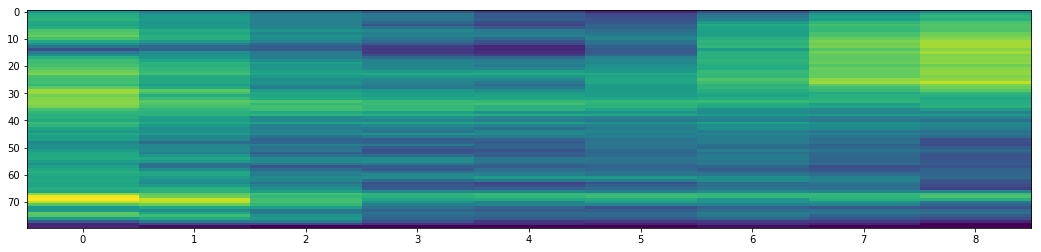

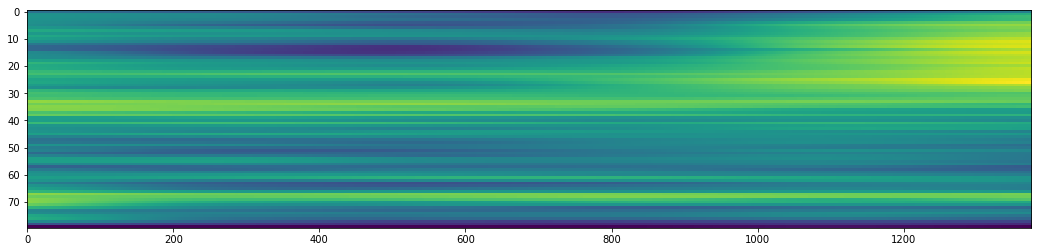

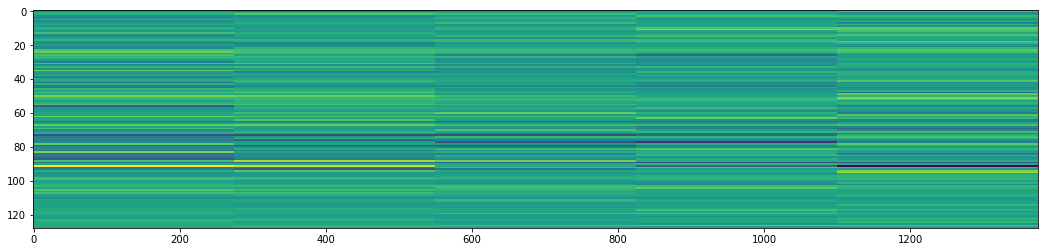

In [23]:
plot_spec(m[0].numpy())
plot_spec(mels[0].cpu().detach().numpy().T)
plot_spec(aux[0].cpu().detach().numpy().T)

In [24]:
global step
step = 0

In [25]:
if not os.path.exists(STEP_PATH):
    np.save(STEP_PATH, step)
step = np.load(STEP_PATH)
step

array(195228)

In [26]:
criterion = nn.NLLLoss().cuda()
optimiser = optim.Adam(model.parameters())
model.train()
def train(model, optimiser, criterion, epochs, batch_size, classes, seq_len, step, lr=1e-4) :
    loss_threshold = 4.0
    trn_loader = DataLoader(dataset, collate_fn=collate, batch_size=batch_size, 
                            num_workers=4, shuffle=True, pin_memory=True)
    for p in optimiser.param_groups : p['lr'] = lr
    for e in range(epochs) :
        running_loss = 0.
        val_loss = 0.
        start = time.time()
        running_loss = 0.
        iters = len(trn_loader)
        for i, (x, m, y) in enumerate(trn_loader) :
            x, m, y = x.cuda(), m.cuda(), y.cuda()
            y_hat = model(x, m)
            y_hat = y_hat.transpose(1, 2).unsqueeze(-1)
            y = y.unsqueeze(-1)
            loss = criterion(y_hat, y)
            optimiser.zero_grad()
            loss.backward()
            optimiser.step()
            running_loss += loss.item()
            speed = (i + 1) / (time.time() - start)
            avg_loss = running_loss / (i + 1)
            step += 1
            if step % 10 == 0:
                print("Epoch: {}/{} -- Batch: {}/{} -- Loss: {:.3f}"
                      " -- Speed: {:.2f} steps/sec -- Step: {}"\
                      .format(e + 1, epochs, i + 1, iters, avg_loss, speed, step))
        torch.save(model.state_dict(), MODEL_PATH)
        np.save(STEP_PATH, step)
        print(' <saved>')

In [27]:
# train(model, optimiser, criterion, epochs=1000, batch_size=64, classes=2**bits, 
#       seq_len=seq_len, step=step, lr=1e-4)

## Generate Samples

In [28]:
def generate(samples=3) :
    global output
    k = step // 1000
    test_mels = [np.load(f'{DATA_PATH}mel/{id}.npy') for id in test_ids[:samples]]
    ground_truth = [np.load(f'{DATA_PATH}quant/{id}.npy') for id in test_ids[:samples]]
    for i, (gt, mel) in enumerate(zip(ground_truth, test_mels)) :
        print('\nGenerating: %i/%i' % (i+1, samples))
#         gt = 2 * gt.astype(np.float32) / (2**bits - 1.) - 1.
        gt = ap.mulaw_decode(gt, 2**bits)
        librosa.output.write_wav(f'{GEN_PATH}{k}k_steps_{i}_target.wav', gt, sr=ap.sample_rate)
        output = model.generate(mel)
        output = ap.mulaw_decode(output, 2**bits)
        librosa.output.write_wav(f'{GEN_PATH}{k}k_steps_{i}_generated.wav', output, sr=ap.sample_rate)


In [29]:
import librosa
generate()


Generating: 1/3




Generating: 2/3




Generating: 3/3


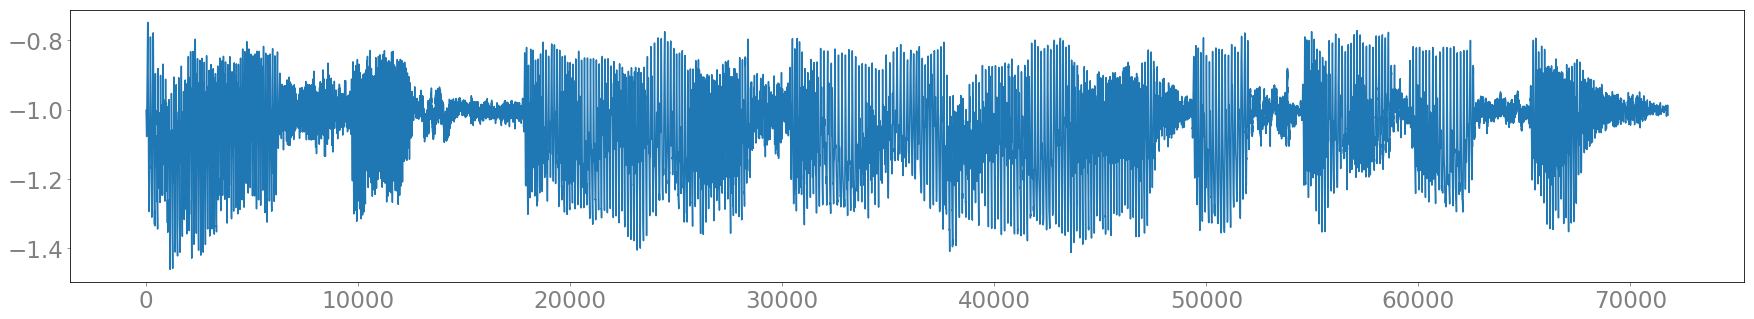

In [30]:
plot(output)